In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from functional import seq
import itertools
import sys

sys.path.append("../")
from plotly_resampler.aggregation import MinMaxAggregator
from agg_utils.path_conf import figure_root_dir, loc_data_dir
from tqdm.auto import tqdm

tqdm.pandas()

from agg_utils.metrics import get_png_path

highlight_color = "#8EA7E9"
palette = [
   px.colors.qualitative.Pastel[0], # MinMaxLTTB
   "#ffc53c", # dark yellow -> LTTB,
   px.colors.qualitative.Pastel[2], # MinMax
]

In [3]:
joined_metrics : bool = True  # set this to true if you have already joined the metrics
if not joined_metrics:
    df_m_tot = pd.read_parquet(loc_data_dir / "plotly_metrics_preselect.parquet").assign(
        aggregator=lambda x: x.aggregator.astype("category"),
        ls=lambda x: x.ls.astype("category"),
        toolkit=lambda x: x.toolkit.astype("category"),
        data=lambda x: x.data.astype("category"),
    )
    df_m_tot = df_m_tot.rename(columns={"lw": "line_width", "ls": "line_shape"})

    df_m_tot["visual_cw"] = 800 / df_m_tot.line_width
    df_m_tot["visual_n_out_ratio"] = df_m_tot.n_out / (df_m_tot.visual_cw)
    df_m_tot["pixel_error_ratio_same_lw"] = (
        df_m_tot["pixel_errors_same_lw"] / df_m_tot["conv_mask_size_same_lw"]
    )
    df_m_tot["path"] = df_m_tot.apply(
        lambda x: str(get_png_path(**x.to_dict())), axis=1
    )
    df_m_tot.to_parquet("df_m_tot_preselect.parquet")
else:
    df_m_tot = pd.read_parquet("df_m_tot_preselect.parquet")
cols = seq(df_m_tot.columns).filter(lambda x: "error" in x and "same_lw" in x).list()
print(cols)
out = (
    df_m_tot[cols]
    .div(df_m_tot["conv_mask_size_same_lw"], axis=0)
    .add_suffix("_ratio_cm")
)
df_m_tot[out.columns] = out
del out, cols

['pixel_errors_same_lw', 'pixel_errors_margin_10_same_lw', 'pixel_errors_margin_20_same_lw', 'pixel_errors_margin_30_same_lw', 'pixel_errors_margin_50_same_lw', 'pixel_errors_margin_75_same_lw', 'pixel_errors_margin_100_same_lw', 'illumination_error_same_lw', 'illumination_error_margin_10_same_lw', 'illumination_error_margin_20_same_lw', 'pixel_error_ratio_same_lw']


## Teaser figure

In [1]:
# MinMaxLTTB for different factors

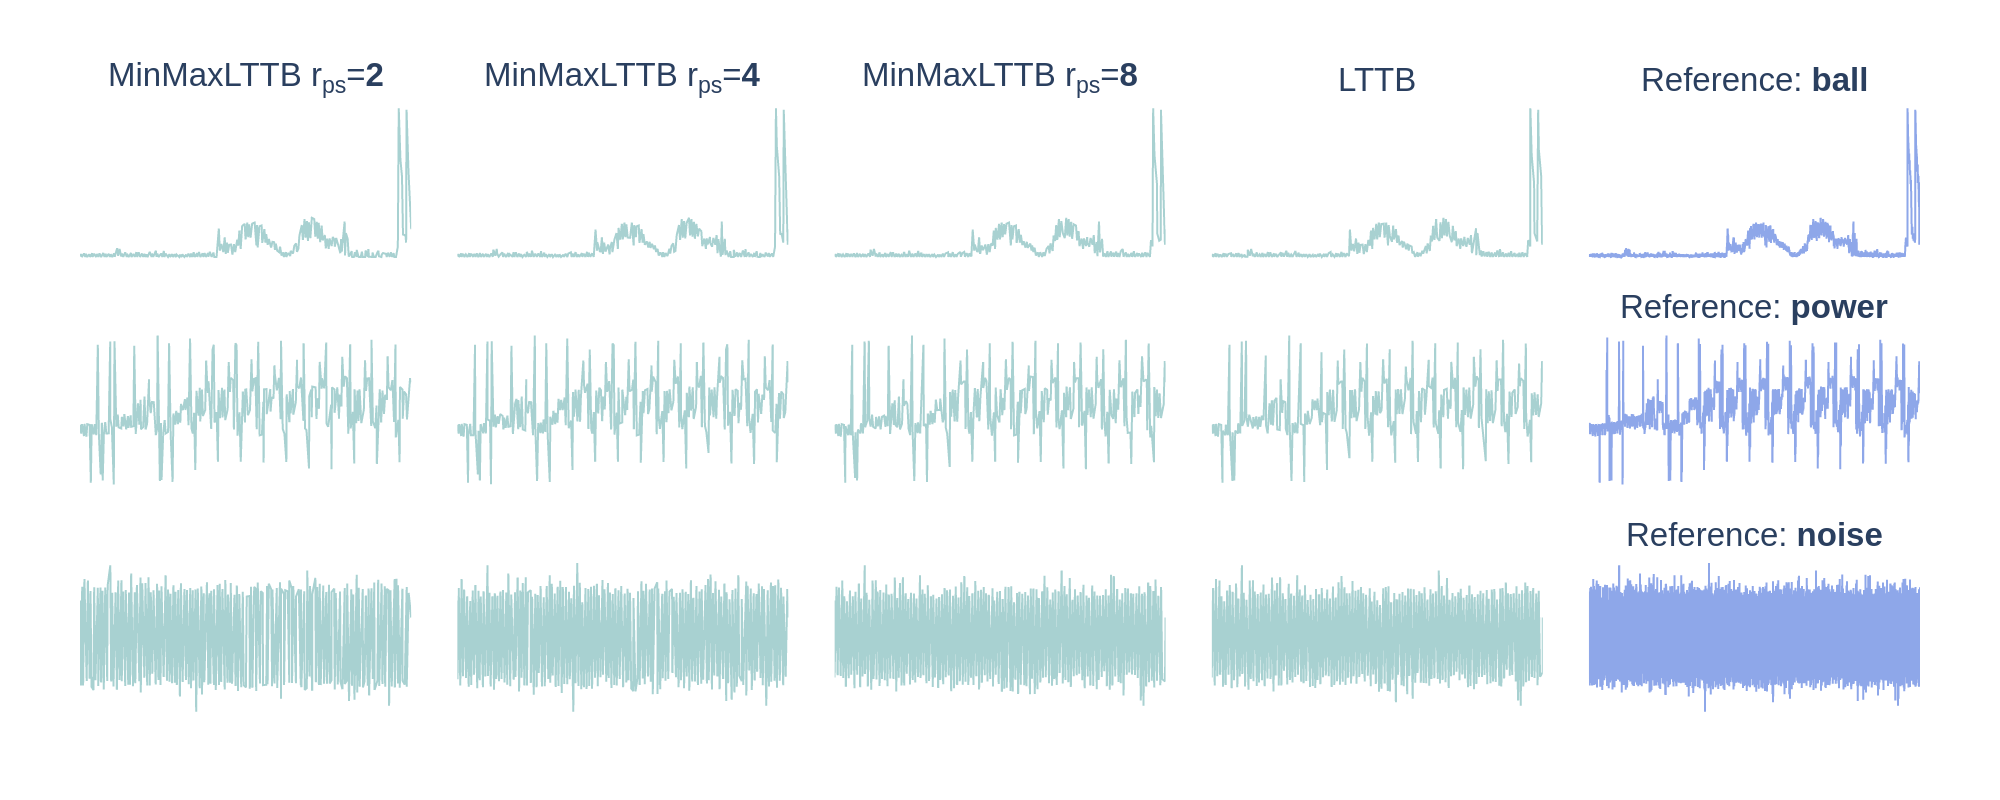

In [21]:
df_vis = df_m_tot
aggregator_factors = [
    ("MinMaxLTTB", 2),
    ("MinMaxLTTB", 4),
    ("MinMaxLTTB", 8),
    # ("MinMaxLTTB", 6),
    ("LTTB", None),
]
n = 200_000
n_out = 240
data = ["ball", "power", "noise"]
line_shape = "linear"
line_width = 2

subplot_titles = [
    l[0] + (f" r<sub>ps</sub>=<b>{l[1]}</b>" if l[1] is not None else "") for l in aggregator_factors
] + [f"Reference: <b>{data[0]}</b>"]
for i in range(len(data) - 1):
    subplot_titles += [""] * len(aggregator_factors)
    subplot_titles += [f"Reference: <b>{data[i+1]}</b>"]

fig = make_subplots(
    rows=len(data),
    cols=len(aggregator_factors) + 1,
    subplot_titles=subplot_titles,
    shared_yaxes="rows",
    shared_xaxes="rows",
    vertical_spacing=0.1,
    horizontal_spacing=0.025,
)
for row_idx, data in enumerate(data, 1):
    df_vis_n = df_vis[
        (df_vis.n == n)
        & (df_vis.n_out == n_out)
        & (df_vis.data == data)
        & (df_vis.line_shape == line_shape)
        & (df_vis.line_width == line_width)
        & (
            df_vis.toolkit == "plotly_preselect"
        )  # doesn't matter - we just get the data
    ]
    for col_idx, (aggregator, factor) in enumerate(aggregator_factors, 1):
        df_vis_n_agg = df_vis_n[
            (df_vis_n.aggregator == aggregator)
            & (
                (df_vis_n.factor == factor)
                if factor is not None
                else (df_vis_n.factor.isna())
            )
        ]
        assert len(df_vis_n_agg) == 1
        s = df_vis_n_agg.iloc[0]
        s = pd.read_parquet(
            Path(s.path).parent.parent
            / "preselect_data"
            / f"{data}_{aggregator}_{n}_{n_out}{'_' + str(factor) if factor is not None else ''}.parquet"
        )
        s = s.set_index(s.columns[0]).iloc[:, 0]
        assert len(s) <= n_out

        fig.add_trace(
            go.Scatter(
                line_width=line_width,
                line_shape=line_shape,
                x=s.index,
                y=s.values,
                name=aggregator,
                showlegend=False,
                line_color="#A8D1D1",  # this is the teal color
            ),
            row=row_idx,
            col=col_idx,
        )
    s = df_vis_n_agg.iloc[0]
    reference_series = pd.read_parquet(
        Path(s.path).parent.parent / "preselect_data" / f"{data}_reference_{n}.parquet"
    )
    reference_series = reference_series.set_index(reference_series.columns[0]).iloc[
        :, 0
    ]

    s_out = MinMaxAggregator()._aggregate(reference_series, 9000)
    fig.add_trace(
        go.Scatter(
            line_width=line_width,
            line_shape={"default": "linear", "steps-mid": "vhv"}.get(line_shape),
            x=s_out.index,
            y=s_out.values,
            showlegend=False,
            line_color=highlight_color,
        ),
        row=row_idx,
        col=col_idx + 1,
    )

fig.update_annotations(font_size=33)
fig.update_yaxes(showticklabels=False, showgrid=False, zeroline=False)
fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False)
fig.update_layout(template="plotly_white", height=860)
fig.show(renderer="png", width=2000, height=800)
fig.write_html('teaser_n_out_240.html')


### Teaser gif

In [41]:
df_vis = df_m_tot
aggregator_factors = [
    ("MinMaxLTTB", 2),
    ("MinMaxLTTB", 4),
    ("MinMaxLTTB", 8),
    ("LTTB", None),
]
n = 200_000

data_list = ["ball", "power", "noise"]
line_shape = "linear"
line_width = 2

subplot_titles = [
    l[0] + (f" r<sub>ps</sub>=<b>{l[1]}</b>" if l[1] is not None else "") for l in aggregator_factors
] + [f"Reference: <b>{data_list[0]}</b>"]
for i in range(len(data_list) - 1):
    subplot_titles += [""] * len(aggregator_factors)
    subplot_titles += [f"Reference: <b>{data_list[i+1]}</b>"]

figs = []
for n_out in np.linspace(200, 600, 5*2 +1):
    n_out = int(n_out)
    print(n_out)
    fig = make_subplots(
        rows=len(data_list),
        cols=len(aggregator_factors) + 1,
        subplot_titles=subplot_titles,
        shared_yaxes="rows",
        shared_xaxes="rows",
        vertical_spacing=0.1,
        horizontal_spacing=0.025,
    )
    for row_idx, data in enumerate(data_list, 1):
        df_vis_n = df_vis[
            (df_vis.n == n)
            & (df_vis.n_out == n_out)
            & (df_vis.data == data)
            & (df_vis.line_shape == line_shape)
            & (df_vis.line_width == line_width)
            & (
                df_vis.toolkit == "plotly_preselect"
            )  # doesn't matter - we just get the data
        ]
        for col_idx, (aggregator, factor) in enumerate(aggregator_factors, 1):
            df_vis_n_agg = df_vis_n[
                (df_vis_n.aggregator == aggregator)
                & (
                    (df_vis_n.factor == factor)
                    if factor is not None
                    else (df_vis_n.factor.isna())
                )
            ]
            assert len(df_vis_n_agg) == 1
            s = df_vis_n_agg.iloc[0]
            s = pd.read_parquet(
                Path(s.path).parent.parent
                / "preselect_data"
                / f"{data}_{aggregator}_{n}_{n_out}{'_' + str(factor) if factor is not None else ''}.parquet"
            )
            s = s.set_index(s.columns[0]).iloc[:, 0]
            assert len(s) <= n_out

            fig.add_trace(
                go.Scatter(
                    line_width=line_width,
                    line_shape={"default": "linear", "steps-mid": "vhv"}.get(line_shape),
                    x=s.index,
                    y=s.values,
                    name=aggregator,
                    showlegend=False,
                    line_color="#A8D1D1",  # this is the teal color
                ),
                row=row_idx,
                col=col_idx,
            )
        s = df_vis_n_agg.iloc[0]
        reference_series = pd.read_parquet(
            Path(s.path).parent.parent / "preselect_data" / f"{data}_reference_{n}.parquet"
        )
        reference_series = reference_series.set_index(reference_series.columns[0]).iloc[
            :, 0
        ]

        s_out = MinMaxAggregator()._aggregate(reference_series, 9000)
        fig.add_trace(
            go.Scatter(
                line_width=line_width,
                line_shape={"default": "linear", "steps-mid": "vhv"}.get(line_shape),
                x=s_out.index,
                y=s_out.values,
                showlegend=False,
                line_color=highlight_color,
            ),
            row=row_idx,
            col=col_idx + 1,
        )

    fig.update_annotations(font_size=33)
    fig.update_yaxes(showticklabels=False, showgrid=False, zeroline=False)
    fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False)
    fig.update_layout(
        template="plotly_white", height=860,
        title={
            "text": f"n_out=<b>{n_out}</b>",
            "y": 0.99,
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
            "font": {"size": 40},
        },
        )
    figs.append(fig.to_image(format='png', width=2000, height=860))



200
240
280
320
360
400
440
480
520
560
600


In [42]:
import imageio
from PIL import Image
import io

images = []
# for fig in (fig_list + fig_list[::-1][1:-1]):
for fig in figs:
    # convert bytes to a 2D PIL image
    png = Image.open(io.BytesIO(fig))
    images.append(png)

imageio.mimsave("../gifs/teaser_preselection_ratio.gif", images, 'GIF', duration=0.7)


## `n_out` trend curves

In [16]:
from agg_utils.path_conf import dataset_dir

btc_series = pd.read_parquet(dataset_dir / "btc_high.parquet").set_index("date")["high"]
ball_speed_series = pd.read_parquet(dataset_dir / "ball_speed.parquet").set_index("ts")[
    "v"
]
power_series = pd.read_parquet(dataset_dir / "electrical_power.parquet").set_index(
    "ts"
)["mf03"]
cinecg = pd.read_parquet(dataset_dir / "cinecg.parquet")["ECG"]
hf_sine = pd.read_parquet(dataset_dir / "hf_sine.parquet")["sine"]
hf_noise = pd.read_parquet(dataset_dir / "hf_noise.parquet")["noise"]

data_dict = {
    "noise": hf_noise,
    "cinecg": cinecg,
    "ball": ball_speed_series.iloc[50_000:],
    "power": power_series,
    "btc": btc_series,
}


lw = [2] - 300 <= n_out <= 1999 - toolkits = ['plotly_preselect'] - factor = [2, 4, 6]


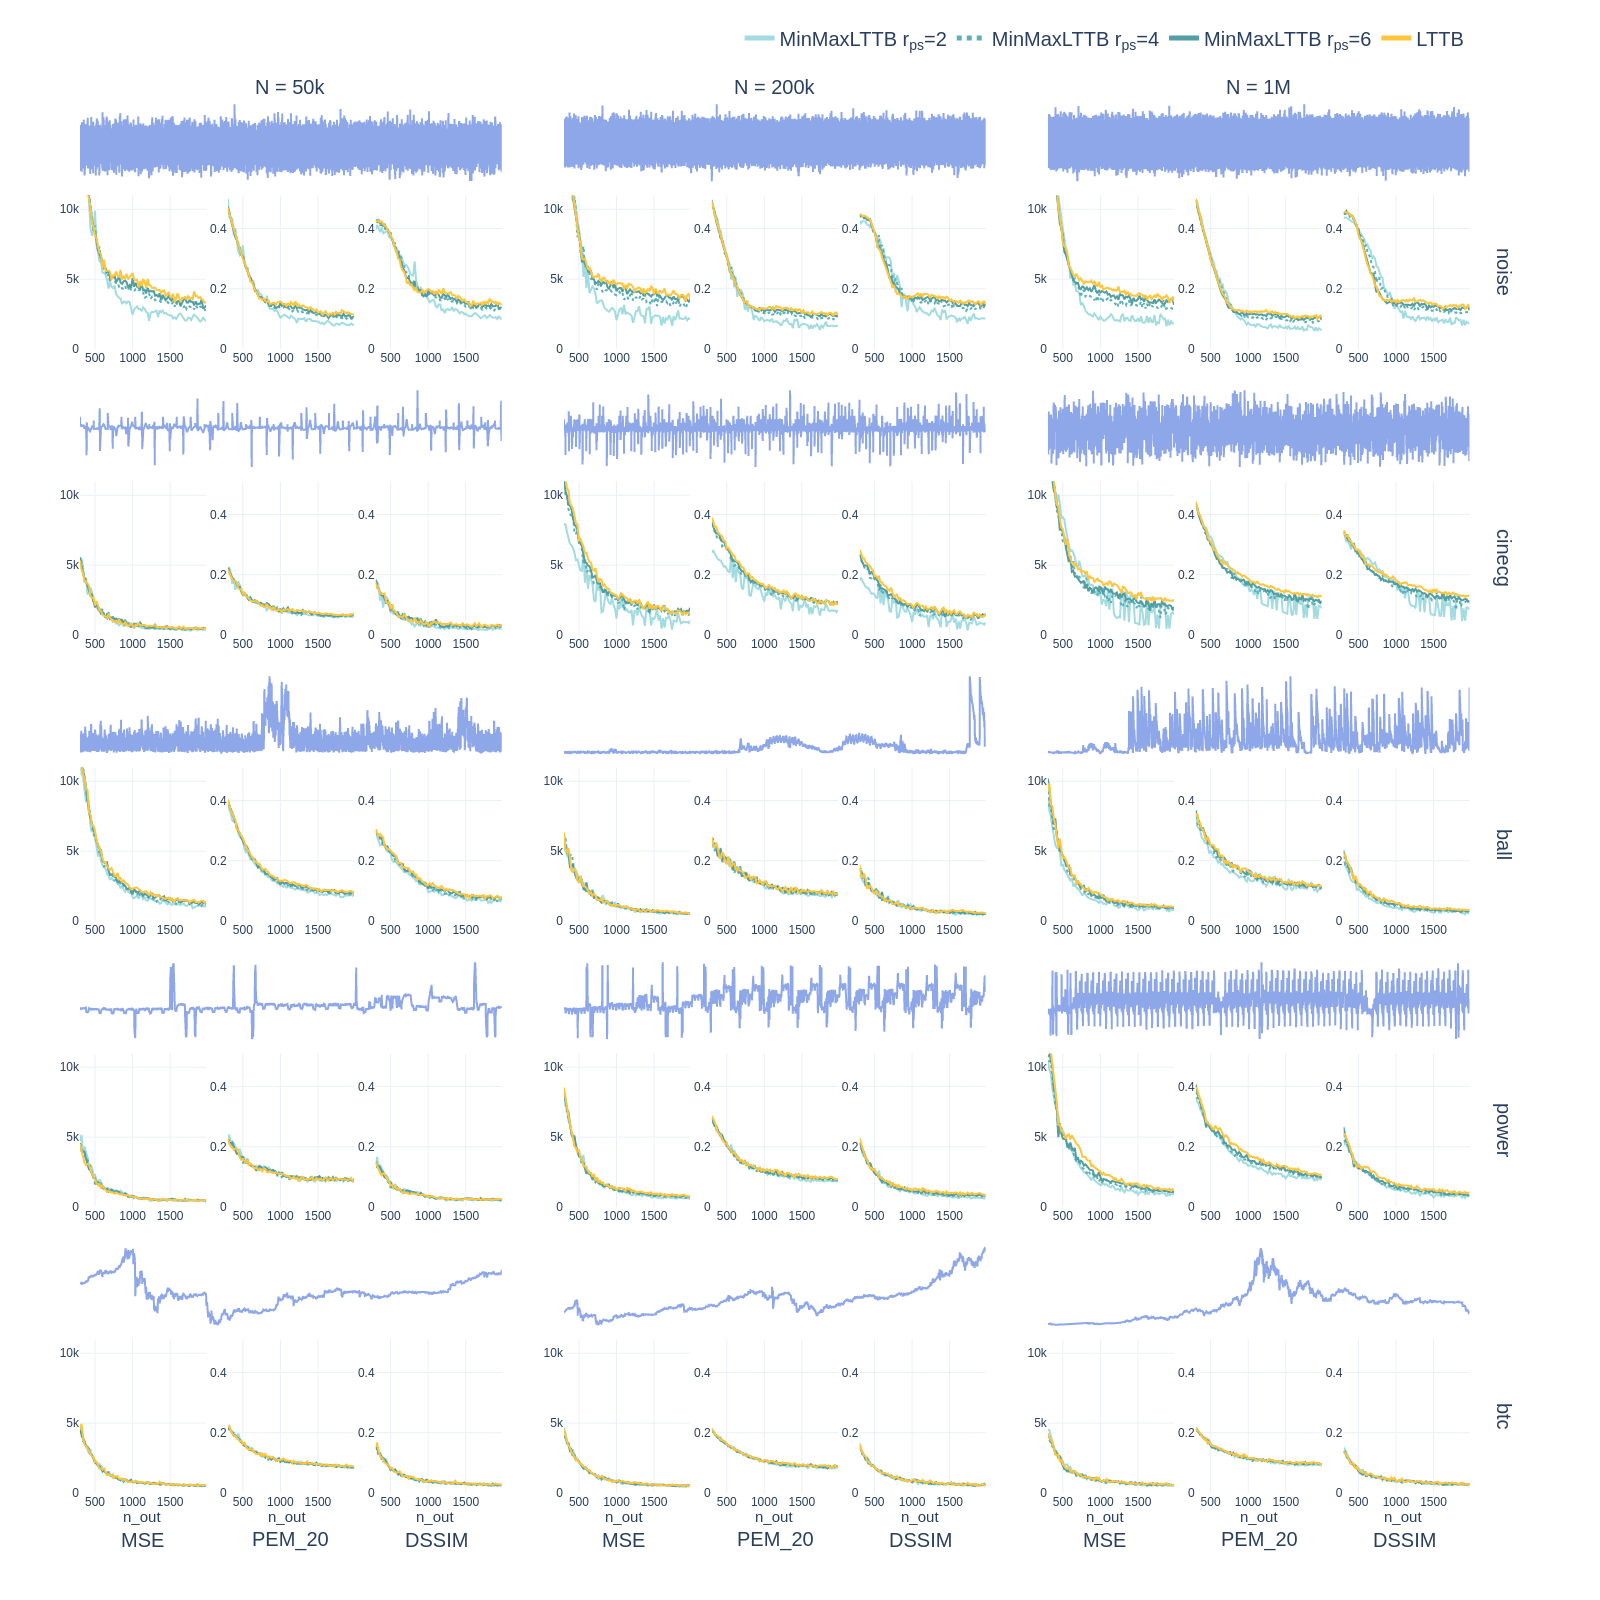

In [44]:
# Paper - vis line - Aggregator as color + also images  - column - n
df_vis = df_m_tot.copy()
aggregator_mapping = {
    "MinMaxAggregator": "MinMax",
    "M4Aggregator": "M4",
    "EveryNthPoint": "EveryNth",
}
df_vis["aggregator"] = df_vis["aggregator"].map(lambda x: aggregator_mapping.get(x, x))

toolkits = ["plotly_preselect"]
data_list = [
    "noise",
    "cinecg",
    "ball",
    "power",
    "btc",
][:]
aggregators = [
    "MinMaxLTTB",
    "LTTB",
    # "MinMax",
]
metrics = [
    "MSE_masked_same_lw",
    "pixel_errors_margin_20_same_lw_ratio_cm",
    "DSSIM_masked_same_lw",
]
line_shape = "linear"
line_widths = [2]
n_out_min, n_out_max = 300, 1999
ns = [50_000, 200_000, 1_000_000]
factors = [2, 4, 6, 8][:3]
# factors = [4]
line_dash_mapping = {2: None, 4: 'dot', 6: None}

minmaxLTTB_factor_color_mapping = { # the teal factors
    # 2: "#94d6db",
    2: "#a3dce0",
    # 4: "#66c5cc",
    4: "#5cb1b8",
    6: "#529ea3",
}

df_vis = df_vis[
    (df_vis.line_width.isin(line_widths))
    & (df_vis.toolkit.isin(toolkits))
    & (df_vis.data.isin(data_list))
    & (df_vis.aggregator.isin(aggregators))
    & (df_vis.n_out <= n_out_max)
    & (df_vis.n_out >= n_out_min)
    & (df_vis.n.isin(ns))
    & (df_vis.line_shape == line_shape)
    & (df_vis.factor.isna() | df_vis.factor.isin(factors))
]
column_widths = [1, 1, 1, 0.15] * len(ns)
column_widths[-1] = 0
specs = []
for i in range(len(data_list)):
    specs += [[{"colspan": 3}, None, None, {}] * len(ns)]
    specs += [[{}] * 4 * len(ns)]
    specs += [[{}] * 4 * len(ns)]
fig = make_subplots(
    cols=(len(metrics) + 1) * len(ns),
    rows=len(data_list) * 3,
    shared_yaxes=False,
    shared_xaxes=False,
    vertical_spacing=0.007,
    horizontal_spacing=0.015,
    column_titles=list(
        itertools.chain(*[[f"N = {n}", ""] for n in ["50k", "200k", "1M"]])
    ),
    column_widths=column_widths,
    row_heights=[0.5, 0.9, 0.1] * len(data_list),
    row_titles=list(itertools.chain(*[["", data_str, ""] for data_str in data_list])),
    specs=specs,
)

font_size = 20
fig.update_annotations(font_size=font_size)


for col_idx, n in enumerate(ns, 1):
    for row_idx, data in enumerate(data_list, 1):
        # add the data to the figure
        s_agg = MinMaxAggregator()._aggregate(data_dict[data].iloc[:n], 3000)
        fig.add_trace(
            go.Scatter(
                showlegend=False,
                line_color=highlight_color,
                x=s_agg.index,
                y=s_agg,
            ),
            row=3 * (row_idx - 1) + 1,
            col=(col_idx - 1) * (len(metrics) + 1) + 1,
        )

        slc = df_vis[(df_vis.n == n) & (df_vis.data == data)].sort_values(by="n_out")
        for sub_col_idx, metric in enumerate(metrics, 1):
            for i, aggregator in enumerate(aggregators):
                agg_slc = slc[slc.aggregator == aggregator]
                for factor in sorted(agg_slc.factor.unique()):
                    agg_slc_factor = agg_slc[
                        (agg_slc.factor == factor)
                        if not np.isnan(factor)
                        else (agg_slc.factor.isna())
                    ]
                    fig.add_trace(
                        go.Scatter(
                            y=agg_slc_factor[metric],
                            x=agg_slc_factor["n_out"],
                            # marker_color=px.colors.qualitative.Pastel[i],
                            line_color="#ffc53c" if np.isnan(factor) else minmaxLTTB_factor_color_mapping[int(factor)],
                            # mode='lines+markers' if factor == 4.0 else 'lines',
                            # marker_symbol='x-thin',
                            marker_symbol='line-ns',
                            marker_line_width=1,
                            marker_size=5,
                            name=aggregator
                            + ("" if np.isnan(factor)  else f" r<sub>ps</sub>={int(factor)}"),
                            # line_width= factor / 2 if not np.isnan(factor) else 2,
                            showlegend=(col_idx == 1)
                            and (row_idx == 1)
                            and (sub_col_idx == 1),
                            line_dash=line_dash_mapping.get(int(factor) if not np.isnan(factor) else factor),
                        ),
                        row=3 * row_idx - 1,
                        col=(col_idx - 1) * (len(metrics) + 1) + sub_col_idx,
                    )

fig.update_yaxes(matches=None, showticklabels=True, zeroline=False, showgrid=True)
fig.update_xaxes(matches=None, showticklabels=False, zeroline=False, showgrid=False)

for i in range(len(data_list)):
    fig.update_yaxes(showticklabels=False, showgrid=False, row=3 * i + 1)

if True:
    n_cols = len(metrics) * len(ns)
    y_metric = -0.023
    y_n_out = -0.005
    for mse_x in [0.246 / n_cols, 3.394 / n_cols, 6.55 / n_cols]:
        # also update the font size
        fig.add_annotation(
            text="MSE",
            font_size=font_size,
            xref="paper",
            yref="paper",
            x=mse_x,
            y=y_metric,
            showarrow=False,
        )
    for pem_x in [1.06 / n_cols, 4.35 / n_cols, 7.625 / n_cols]:
        # also update the font size
        fig.add_annotation(
            text="PEM_20",
            font_size=font_size,
            xref="paper",
            yref="paper",
            x=pem_x,
            y=y_metric,
            showarrow=False,
        )
    for dssim_x in [2.02 / n_cols, 5.25 / n_cols, 8.485 / n_cols]:
        # also update the font size
        fig.add_annotation(
            text="DSSIM",
            font_size=font_size,
            xref="paper",
            yref="paper",
            x=dssim_x,
            y=y_metric,
            showarrow=False,
        )
    for n_out_x in [0.255, 1.16, 2.09, 3.4, 4.34, 5.25, 6.54, 7.5, 8.4]:
        fig.add_annotation(
            text="n_out",
            font_size=font_size - 5,
            xref="paper",
            yref="paper",
            x=n_out_x / n_cols,
            y=y_n_out,
            # align="center",
            showarrow=False,
        )


for row_idx in range(1, len(data_list) + 1):
    fig.update_xaxes(showgrid=True, showticklabels=True, row=3 * row_idx - 1)


for i in range(len(ns)):
    offset = i * (len(metrics) + 1)
    for row_idx in range(1, len(data_list) + 1):
        fig.update_yaxes(range=[0, 11000], col=1 + offset, row=row_idx * 3 - 1)
        fig.update_yaxes(range=[0.00, 0.51], col=2 + offset, row=row_idx * 3 - 1)
        fig.update_yaxes(range=[0.00, 0.51], col=3 + offset, row=row_idx * 3 - 1)
        # if row_idx != len(data_list):
        #     fig.update_xaxes(title_text='n_out', col=1 + offset, row=row_idx * 3)
        #     fig.update_xaxes(title_text='n_out', col=2 + offset, row=row_idx * 3)
        #     fig.update_xaxes(title_text='n_out', col=3 + offset, row=row_idx * 3)


print(
    f"lw = {line_widths} - {n_out_min} <= n_out <= {n_out_max} - toolkits = {toolkits} - factor = {factors}"
)
fig.update_layout(
    height=1500,
    title_x=0.5,
    template="plotly_white",
    boxgap=0.1,
    # boxmode="group",
    legend=dict(
        title_text="",
        orientation="h",
        yanchor="bottom",
        itemsizing="constant",
        y=1.03,
        xanchor="right",
        x=0.965,
        font_size=font_size,
    ),
).show(renderer="png", width=1600, height=1600)
fig.write_html('vis_repr_minmax.html')

## Animations

lw = [2] - 300 <= n_out <= 1999 - toolkits = ['plotly_preselect'] - factor = [1, 2, 3, 4, 6, 8]


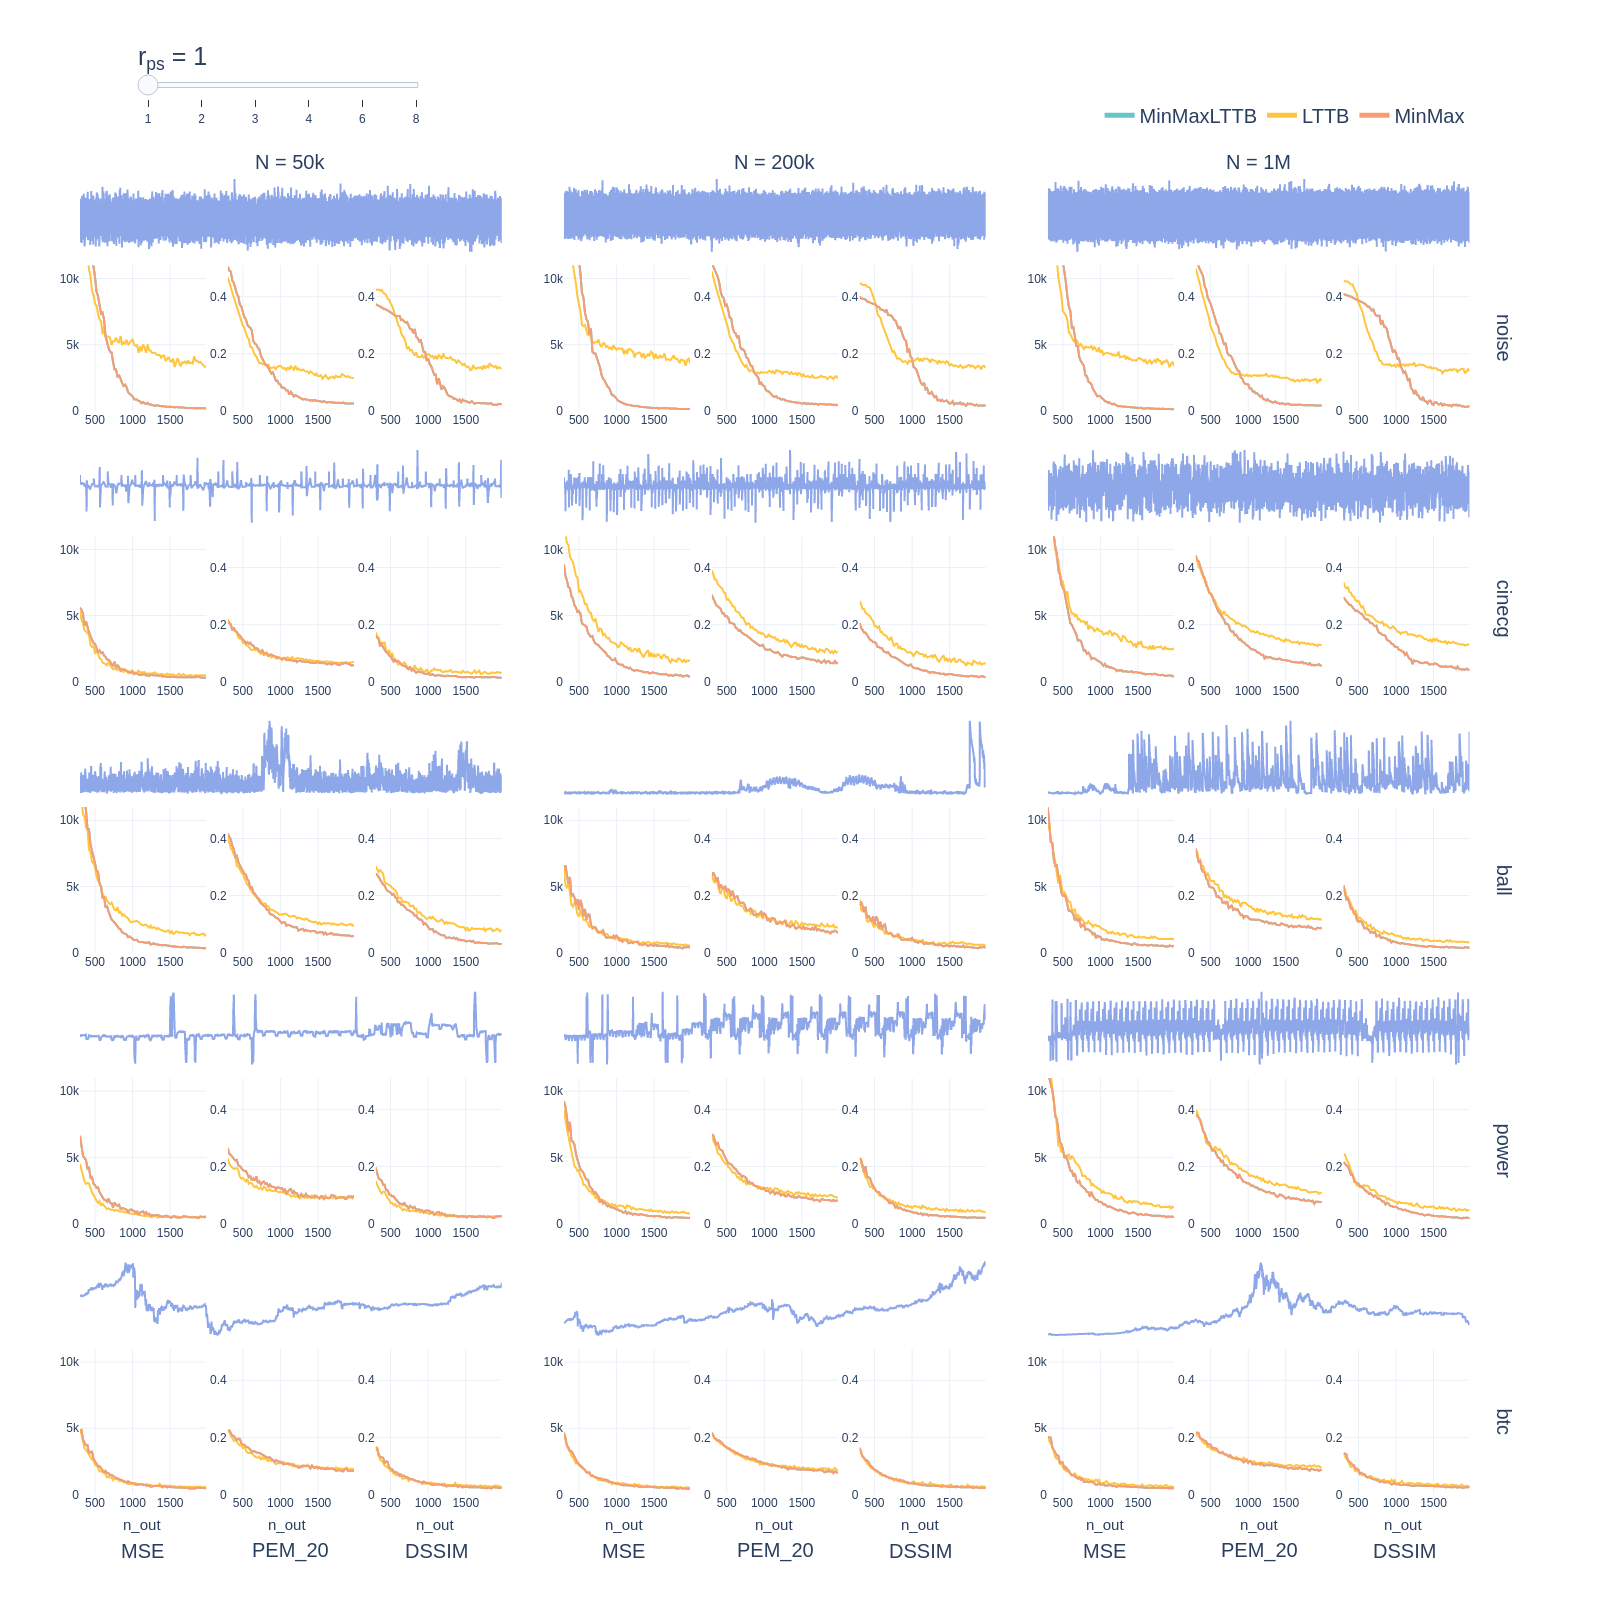

In [17]:
# Paper - vis line - Aggregator as color + also images  - column - n
df_vis = df_m_tot.copy()
aggregator_mapping = {
    "MinMaxAggregator": "MinMax",
    "M4Aggregator": "M4",
    "EveryNthPoint": "EveryNth",
}
df_vis["aggregator"] = df_vis["aggregator"].map(lambda x: aggregator_mapping.get(x, x))

toolkits = ["plotly_preselect"]
data_list = [
    "noise",
    "cinecg",
    "ball",
    "power",
    "btc",
][:]
aggregators = [
    "MinMaxLTTB",
    "LTTB",
    "MinMax",
]
metrics = [
    "MSE_masked_same_lw",
    "pixel_errors_margin_20_same_lw_ratio_cm",
    "DSSIM_masked_same_lw",
]
line_shape = "linear"
line_widths = [2]
n_out_min, n_out_max = 300, 1999
ns = [50_000, 200_000, 1_000_000]
factors = [1, 2, 3, 4, 6, 8][:]
# factors = [4]

df_vis = df_vis[
    (df_vis.line_width.isin(line_widths))
    & (df_vis.toolkit.isin(toolkits))
    & (df_vis.data.isin(data_list))
    & (df_vis.aggregator.isin(aggregators))
    & (df_vis.n_out <= n_out_max)
    & (df_vis.n_out >= n_out_min)
    & (df_vis.n.isin(ns))
    & (df_vis.line_shape == line_shape)
    & (df_vis.factor.isna() | df_vis.factor.isin(factors))
]
column_widths = [1, 1, 1, 0.15] * len(ns)
column_widths[-1] = 0
specs = []
for i in range(len(data_list)):
    specs += [[{"colspan": 3}, None, None, {}] * len(ns)]
    specs += [[{}] * 4 * len(ns)]
    specs += [[{}] * 4 * len(ns)]
fig = make_subplots(
    cols=(len(metrics) + 1) * len(ns),
    rows=len(data_list) * 3,
    shared_yaxes=False,
    shared_xaxes=False,
    vertical_spacing=0.007,
    horizontal_spacing=0.015,
    column_titles=list(
        itertools.chain(*[[f"N = {n}", ""] for n in ["50k", "200k", "1M"]])
    ),
    column_widths=column_widths,
    row_heights=[0.5, 0.9, 0.1] * len(data_list),
    row_titles=list(itertools.chain(*[["", data_str, ""] for data_str in data_list])),
    specs=specs,
)

font_size = 20
fig.update_annotations(font_size=font_size)

sliders_dict = {
    "active": 0,
    "yanchor": "bottom",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": font_size + 5},
        "prefix": "r<sub>ps</sub> = ",
        "visible": True,
        "xanchor": "left",
    },
    "transition": {"duration": 800, "easing": "cubic-in-out"},
    "len": 0.2,
    "x": 0.04,
    "y": 1.04,
    "steps": [],
}

for factor in factors:
    df_vis_f = df_vis[df_vis.factor.isna() | (df_vis.factor == factor)]
    fig_frame = make_subplots(
        cols=(len(metrics) + 1) * len(ns),
        rows=len(data_list) * 3,
        shared_yaxes=False,
        shared_xaxes=False,
        vertical_spacing=0.007,
        horizontal_spacing=0.015,
        column_titles=list(
            itertools.chain(*[[f"N = {n}", ""] for n in ["50k", "200k", "1M"]])
        ),
        column_widths=column_widths,
        row_heights=[0.5, 0.9, 0.1] * len(data_list),
        row_titles=list(
            itertools.chain(*[["", data_str, ""] for data_str in data_list])
        ),
        specs=specs,
    )
    fig_frame.layout = fig.layout
    frame = {"data": [], "name": f"{factor}"}
    for col_idx, n in enumerate(ns, 1):
        for row_idx, data in enumerate(data_list, 1):
            # add the data to the figure
            s_agg = MinMaxAggregator()._aggregate(data_dict[data].iloc[:n], 3000)
            fig_frame.add_trace(
                go.Scatter(
                    showlegend=False,
                    line_color=highlight_color,
                    x=s_agg.index,
                    y=s_agg,
                ),
                row=3 * (row_idx - 1) + 1,
                col=(col_idx - 1) * (len(metrics) + 1) + 1,
            )

            slc = df_vis_f[(df_vis_f.n == n) & (df_vis_f.data == data)].sort_values(
                by="n_out"
            )
            for sub_col_idx, metric in enumerate(metrics, 1):
                for i, aggregator in enumerate(aggregators):
                    # print(
                    #     "aggregator",
                    #     aggregator,
                    #     slc[slc.aggregator == aggregator][metric].shape,
                    # )
                    fig_frame.add_trace(
                        go.Scatter(
                            y=slc[slc.aggregator == aggregator][metric],
                            x=slc[slc.aggregator == aggregator]["n_out"],
                            marker_color=palette[i],
                            name=aggregator,
                            showlegend=(col_idx == 1)
                            and (row_idx == 1)
                            and (sub_col_idx == 1),
                        ),
                        row=3 * row_idx - 1,
                        col=(col_idx - 1) * (len(metrics) + 1) + sub_col_idx,
                    )

    if factor == factors[0]:
        fig.update(data=list(fig_frame.data))

    frame["data"] = list(fig_frame.data)
    frame["traces"] = list(np.arange(len(fig_frame.data)))
    fig["frames"] += (frame,)

    slider_step = {
        "args": [
            [str(factor)],
            {
                "frame": {"duration": 600, "redraw": False},
                "mode": "immediate",  # TODO: what does this mean?
                "transition": {"duration": 600},
            },
        ],
        "label": str(factor),
        "method": "animate",
    }
    sliders_dict["steps"].append(slider_step)

fig["layout"]["sliders"] = [sliders_dict]
fig.update_yaxes(matches=None, showticklabels=True, zeroline=False, showgrid=True)
fig.update_xaxes(matches=None, showticklabels=False, zeroline=False, showgrid=False)

for i in range(len(data_list)):
    fig.update_yaxes(showticklabels=False, showgrid=False, row=3 * i + 1)

if True:
    n_cols = len(metrics) * len(ns)
    y_metric = -0.033
    y_n_out = -0.011
    for mse_x in [0.246 / n_cols, 3.394 / n_cols, 6.55 / n_cols]:
        # also update the font size
        fig.add_annotation(
            text="MSE",
            font_size=font_size,
            xref="paper",
            yref="paper",
            x=mse_x,
            y=y_metric,
            showarrow=False,
        )
    for pem_x in [1.06 / n_cols, 4.35 / n_cols, 7.625 / n_cols]:
        # also update the font size
        fig.add_annotation(
            text="PEM_20",
            font_size=font_size,
            xref="paper",
            yref="paper",
            x=pem_x,
            y=y_metric,
            showarrow=False,
        )
    for dssim_x in [2.02 / n_cols, 5.25 / n_cols, 8.485 / n_cols]:
        # also update the font size
        fig.add_annotation(
            text="DSSIM",
            font_size=font_size,
            xref="paper",
            yref="paper",
            x=dssim_x,
            y=y_metric,
            showarrow=False,
        )
    for n_out_x in [0.255, 1.16, 2.09, 3.4, 4.34, 5.25, 6.54, 7.5, 8.4]:
        fig.add_annotation(
            text="n_out",
            font_size=font_size - 5,
            xref="paper",
            yref="paper",
            x=n_out_x / n_cols,
            y=y_n_out,
            # align="center",
            showarrow=False,
        )


for row_idx in range(1, len(data_list) + 1):
    fig.update_xaxes(showgrid=True, showticklabels=True, row=3 * row_idx - 1)


for i in range(len(ns)):
    offset = i * (len(metrics) + 1)
    for row_idx in range(1, len(data_list) + 1):
        fig.update_yaxes(range=[0, 11000], col=1 + offset, row=row_idx * 3 - 1)
        fig.update_yaxes(range=[0.00, 0.51], col=2 + offset, row=row_idx * 3 - 1)
        fig.update_yaxes(range=[0.00, 0.51], col=3 + offset, row=row_idx * 3 - 1)
        # if row_idx != len(data_list):
        #     fig.update_xaxes(title_text='n_out', col=1 + offset, row=row_idx * 3)
        #     fig.update_xaxes(title_text='n_out', col=2 + offset, row=row_idx * 3)
        #     fig.update_xaxes(title_text='n_out', col=3 + offset, row=row_idx * 3)


print(
    f"lw = {line_widths} - {n_out_min} <= n_out <= {n_out_max} - toolkits = {toolkits} - factor = {factors}"
)
fig.update_layout(
    height=1300,
    title_x=0.5,
    template="plotly_white",
    boxgap=0.1,
    # boxmode="group",
    legend=dict(
        title_text="",
        orientation="h",
        yanchor="bottom",
        itemsizing="constant",
        y=1.03,
        xanchor="right",
        x=0.965,
        font_size=font_size,
    ),
).show(renderer="png", width=1600, height=1600)
fig.write_html("../animations/frame_preselection_ratio.html")


## Gifs

In [18]:
df_vis[df_vis.aggregator == 'MinMax'].factor.unique()

array([nan])

In [22]:
# Paper - vis line - Aggregator as color + also images  - column - n
fig_list = []

toolkits = ["plotly_preselect"]
data_list = [
    "noise",
    "cinecg",
    "ball",
    "power",
    "btc",
][:]
# aggregators = ["LTTB", "MinMaxLTTB", 'MinMax'][::]
aggregators = [
    "MinMaxLTTB",
     "LTTB", 
     'MinMax',
][::]
metrics = [
    "MSE_masked_same_lw",
    "pixel_errors_margin_20_same_lw_ratio_cm",
    "DSSIM_masked_same_lw",
]
line_shape = "linear"
line_widths = [2]
n_out_min, n_out_max = 300, 1999
ns = [ 50_000, 200_000, 1_000_000 ]
for factor in [1, 2, 3, 4, 5, 6, 7, 8]:
# for factor in [2, 3, 4]:
    df_vis = df_m_tot.copy()
    aggregator_mapping = {
        "MinMaxAggregator": "MinMax",
        "M4Aggregator": "M4",
        "EveryNthPoint": "EveryNth",
    }
    df_vis["aggregator"] = df_vis["aggregator"].map(lambda x: aggregator_mapping.get(x, x))
    df_vis = df_vis[
        (df_vis.line_width.isin(line_widths))
        & (df_vis.toolkit.isin(toolkits))
        & (df_vis.data.isin(data_list))
        & (df_vis.aggregator.isin(aggregators))
        & (df_vis.n_out <= n_out_max)
        & (df_vis.n_out >= n_out_min)
        & (df_vis.n.isin(ns))
        & (df_vis.line_shape == line_shape)
        & (df_vis.factor.isna() | (df_vis.factor == factor))
    ]
    column_widths = [1, 1, 1, 0.15] * len(ns)
    column_widths[-1] = 0
    specs = []
    for i in range(len(data_list)):
        specs += [[{"colspan": 3}, None, None, {}] * len(ns)]
        specs += [[{}] * 4 * len(ns)]
        specs += [[{}] * 4 * len(ns)]
    fig = make_subplots(
        cols=(len(metrics) + 1) * len(ns),
        rows=len(data_list) * 3,
        shared_yaxes=False,
        shared_xaxes=False,
        vertical_spacing=0.007,
        horizontal_spacing=0.015,
        column_titles=list(
            itertools.chain(*[[f"N = {n}", ""] for n in ["50k", "200k", "1M"]])
        ),
        column_widths=column_widths,
        row_heights=[0.5, 0.9, 0.1] * len(data_list),
        row_titles=list(itertools.chain(*[["", data_str, ""] for data_str in data_list])),
        specs=specs,
    )

    font_size = 20
    fig.update_annotations(font_size=font_size)

    for col_idx, n in enumerate(ns, 1):
        for row_idx, data in enumerate(data_list, 1):
            # add the data to the figure
            s_agg = MinMaxAggregator()._aggregate(data_dict[data].iloc[:n], 3000)
            fig.add_trace(
                go.Scatter(
                    showlegend=False,
                    line_color=highlight_color,
                    x=s_agg.index,
                    y=s_agg,
                ),
                row=3 * (row_idx - 1) + 1,
                col=(col_idx - 1) * (len(metrics) + 1) + 1,
            )

            slc = df_vis[(df_vis.n == n) & (df_vis.data == data)].sort_values(by="n_out")
            for sub_col_idx, metric in enumerate(metrics, 1):
                for i, aggregator in enumerate(aggregators):
                    fig.add_trace(
                        go.Scatter(
                            y=slc[slc.aggregator == aggregator][metric],
                            x=slc[slc.aggregator == aggregator]["n_out"],
                            # marker_color=px.colors.qualitative.Pastel[i],
                            # line_color=px.colors.qualitative.Pastel[i],
                            line_color=palette[i],
                            name=aggregator,
                            showlegend=(col_idx == 1)
                            and (row_idx == 1)
                            and (sub_col_idx == 1),
                        ),
                        row=3 * row_idx - 1,
                        col=(col_idx - 1) * (len(metrics) + 1) + sub_col_idx,
                    )

    fig.update_yaxes(matches=None, showticklabels=True, zeroline=False, showgrid=True)
    fig.update_xaxes(matches=None, showticklabels=False, zeroline=False, showgrid=False)

    for i in range(len(data_list)):
        fig.update_yaxes(showticklabels=False, showgrid=False, row=3 * i + 1)

    if True:
        n_cols = len(metrics) * len(ns)
        y_metric = -0.04
        y_n_out = -0.015
        for mse_x in [0.246 / n_cols, 3.394 / n_cols, 6.55 / n_cols]:
            # also update the font size
            fig.add_annotation(
                text="MSE",
                font_size=font_size,
                xref="paper",
                yref="paper",
                x=mse_x,
                y=y_metric,
                showarrow=False,
            )
        for pem_x in [1.06 / n_cols, 4.35 / n_cols, 7.625 / n_cols]:
            # also update the font size
            fig.add_annotation(
                text="PEM_20",
                font_size=font_size,
                xref="paper",
                yref="paper",
                x=pem_x,
                y=y_metric,
                showarrow=False,
            )
        for dssim_x in [2.02 / n_cols, 5.25 / n_cols, 8.485 / n_cols]:
            # also update the font size
            fig.add_annotation(
                text="DSSIM",
                font_size=font_size,
                xref="paper",
                yref="paper",
                x=dssim_x,
                y=y_metric,
                showarrow=False,
            )
        for n_out_x in [0.255, 1.16, 2.09, 3.4, 4.34, 5.25, 6.54, 7.5, 8.4]:
            fig.add_annotation(
                text="n_out",
                font_size=font_size - 5,
                xref="paper",
                yref="paper",
                x=n_out_x / n_cols,
                y=y_n_out,
                # align="center",
                showarrow=False,
            )


    for row_idx in range(1, len(data_list) + 1):
        fig.update_xaxes(showgrid=True, showticklabels=True, row=3 * row_idx - 1)


    for i in range(len(ns)):
        offset = i * (len(metrics) + 1)
        for row_idx in range(1, len(data_list) + 1):
            fig.update_yaxes(range=[0, 11000], col=1 + offset, row=row_idx * 3 - 1)
            fig.update_yaxes(range=[0.00, 0.51], col=2 + offset, row=row_idx * 3 - 1)
            fig.update_yaxes(range=[0.00, 0.51], col=3 + offset, row=row_idx * 3 - 1)

    print(
        f"lw = {line_widths} - {n_out_min} <= n_out <= {n_out_max} - toolkits = {toolkits} - factor = {factor}"
    )
    fig.update_layout(
        height=1600,
        width=1400,
        title=f'MinMax preselection ratio = <b>{factor}</b>',
        title_font_size=font_size + 2,
        title_x=0.5,
        template="plotly_white",
        boxgap=0.1,
        legend=dict(
            title_text="",
            orientation="h",
            yanchor="bottom",
            itemsizing="constant",
            y=1.03,
            xanchor="right",
            x=0.965,
            font_size=font_size,
        )
    )
    fig_list.append(fig.to_image(format='png', width=1400, height=1100))

lw = [2] - 300 <= n_out <= 1999 - toolkits = ['plotly_preselect'] - factor = 1
lw = [2] - 300 <= n_out <= 1999 - toolkits = ['plotly_preselect'] - factor = 2
lw = [2] - 300 <= n_out <= 1999 - toolkits = ['plotly_preselect'] - factor = 3
lw = [2] - 300 <= n_out <= 1999 - toolkits = ['plotly_preselect'] - factor = 4
lw = [2] - 300 <= n_out <= 1999 - toolkits = ['plotly_preselect'] - factor = 5
lw = [2] - 300 <= n_out <= 1999 - toolkits = ['plotly_preselect'] - factor = 6
lw = [2] - 300 <= n_out <= 1999 - toolkits = ['plotly_preselect'] - factor = 7
lw = [2] - 300 <= n_out <= 1999 - toolkits = ['plotly_preselect'] - factor = 8


In [23]:
import imageio
from PIL import Image
import io

images = []
# for fig in (fig_list + fig_list[::-1][1:-1]):
for fig in fig_list:
    # convert bytes to a 2D PIL image
    png = Image.open(io.BytesIO(fig))
    images.append(png)

imageio.mimsave("../gifs/visual_representativeness_preselection_ratio.gif", images, duration=1)